# Earthquake_prac
> graph laplacian

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA]

In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

- t = Year
- x = Latitude
- y = Longitude
- f = Magnitude

##### 1. 데이터 정의

In [426]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="1970"').reset_index().iloc[:,1:]
_df

,Date,Latitude,Longitude,Magnitude,Year
0,01/01/1970,-29.4000,-177.1690,5.6,1970
1,01/04/1970,24.1850,102.5430,7.1,1970
2,01/05/1970,23.9840,102.7320,5.9,1970
3,01/06/1970,-9.5830,151.4930,6.3,1970
4,01/07/1970,15.7850,-59.8080,6.0,1970
...,...,...,...,...,...
21951,12/28/2016,38.3917,-118.8941,5.6,2016
21952,12/28/2016,38.3777,-118.8957,5.5,2016
21953,12/28/2016,36.9179,140.4262,5.9,2016
21954,12/29/2016,-9.0283,118.6639,6.3,2016


##### 2. $f(x) = y + \epsilon$ 정의
- $y$ = Magnitude,  지진 규모로 정의

In [427]:
f_true = _df.loc[:,"Magnitude"]

In [428]:
f = f_true + np.random.normal(scale=0.2,size=len(f_true))

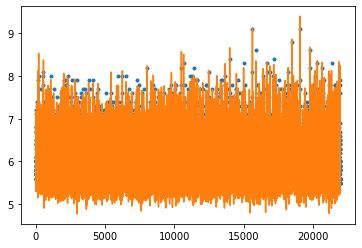

In [429]:
plt.plot(f_true,'.')
plt.plot(f,'-')

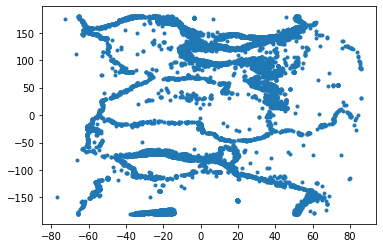

In [430]:
plt.plot( _df.Latitude,_df.Longitude,'.')

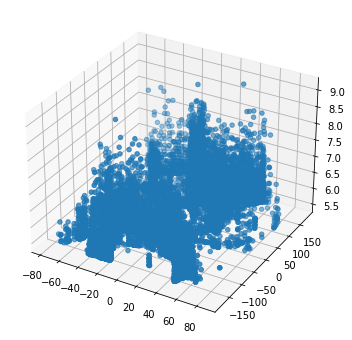

In [431]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(_df.Latitude, _df.Longitude, _df.Magnitude)
#ax.scatter(_df.Latitude, _df.Longitude, 0)

In [432]:
from mpl_toolkits.basemap import Basemap

In [433]:
#collapse

from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

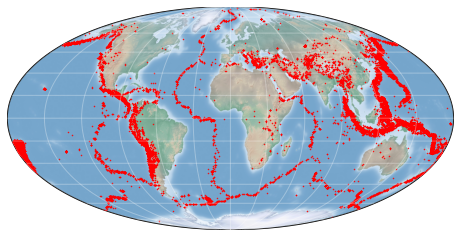

In [434]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='moll', resolution=None,
            lat_0=0, lon_0=0)
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
m.plot(x, y, 'r.', markersize=1)
draw_map(m)

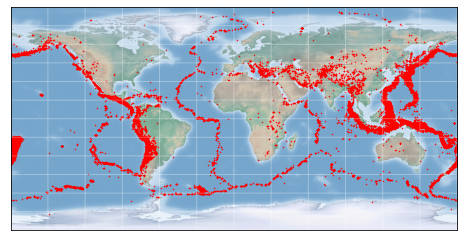

In [435]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
m.plot(x, y, 'r.', markersize=1)
draw_map(m)

##### 3. $(x_i,y_i)$와 $(x_j,y_j)$ 사이의 유클리드 거리 정의
- $x$ = Latitude, 위도로 정의
- $y$ = Longitude, 경도로 정의
    - 반대편으로 갈 수 있는 경우 반대편 각을 구하기 위하여 경도 차이의 절대값이 180도를 넘는 경우 360도를 빼주는 조건 추가

$$dist((x_i,y_i),(x_j,y_j)) = \sqrt{((x_j-x_i)^2-(y_j-y_i)^2}$$

In [436]:
def dist(i,j):
    if abs( _df.Longitude[j] - _df.Longitude[i] ) >= 180: 
        return np.sqrt( ( ( _df.Latitude[j] - _df.Latitude[i] )**2) + ( ( _df.Longitude[j] - _df.Longitude[i] -360)**2) )  
    else:
        return np.sqrt( ( ( _df.Latitude[j] - _df.Latitude[i] )**2) + ( ( _df.Longitude[j] - _df.Longitude[i])**2) )

##### 4. 거리를 이용한 $W_{i,j}$ 행렬 정의
- a weighted adjacency matrix $W$
- 동일한 지점 상의 거리는 0이 되어 $W_{i,j}$가 1이 될 것이다(대각행렬은 모두 1이 될터.)

$$W_{i,j}=\begin{cases}{exp(-\frac{[dist(i,j)]^2}{2\theta^2})} & \quad \text{if } dist(i,j) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [437]:
def weight(i,j,theta=10,kappa=100):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

6시간 정도 걸림

In [438]:
W = np.array([[weight(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [439]:
W.round(3)

array([[1.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 1.   , 1.   , ..., 0.   , 0.001, 0.   ],
       [0.   , 1.   , 1.   , ..., 0.   , 0.001, 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 1.   , 0.   , 0.994],
       [0.   , 0.001, 0.001, ..., 0.   , 1.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.994, 0.   , 1.   ]])

그래프

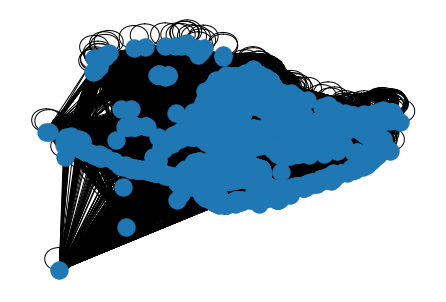

In [440]:
nx.draw(nx.Graph(W))

##### 5. $W_{i,j}$ 행렬을 이용한 차수 행렬 정의
- $D$ = Degree Matrix

In [441]:
D = np.diag(W.sum(axis=1))

In [442]:
D

array([[1705.72271377,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,  398.87951549,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,  402.09836598, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ..., 1645.25743926,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
        1378.85850447,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , 1669.04730747]])

##### 6. Graph Laplacian matrix 정의
- $L = D - W$

In [443]:
L = D - W

In [444]:
L

array([[ 1.70472271e+03,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.85157648e-21,  3.97879515e+02, -9.99619462e-01, ...,
        -3.40083996e-04, -1.09715637e-03, -2.19061203e-04],
       [-7.58202768e-21, -9.99619462e-01,  4.01098366e+02, ...,
        -3.55959921e-04, -1.20872772e-03, -2.29493113e-04],
       ...,
       [-3.50796706e-14, -3.40083996e-04, -3.55959921e-04, ...,
         1.64425744e+03, -2.44062848e-06, -9.94026527e-01],
       [-1.43869509e-10, -1.09715637e-03, -1.20872772e-03, ...,
        -2.44062848e-06,  1.37785850e+03, -1.57119318e-06],
       [-3.85134687e-14, -2.19061203e-04, -2.29493113e-04, ...,
        -9.94026527e-01, -1.57119318e-06,  1.66804731e+03]])

##### 7. 고유값 분해
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$

In [445]:
λ, Ψ = np.linalg.eig(L)

In [446]:
Λ = np.diag(λ)

---

푸리에

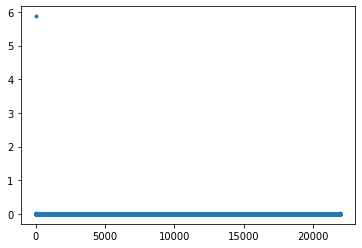

In [447]:
fbar = np.abs(np.fft.fft(f))/len(f)
plt.plot(fbar,'.')

In [448]:
fbar[0] 

5.872639545178326

In [449]:
len(f)/2

10978.0

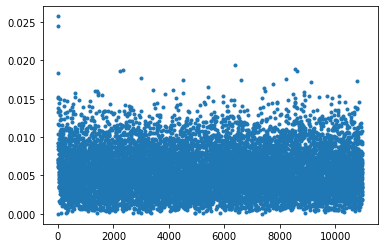

In [475]:
fbar2=np.zeros(10978)
#fbar2[0] = fbar[0] 
fbar2[0] = 0
fbar2[1:10978] = 2*fbar[1:10978]
plt.plot(fbar2,'.')

In [451]:
fbar2[:10]

array([0.        , 0.01164706, 0.02439952, 0.01384569, 0.0257273 ,
       0.01830837, 0.01518772, 0.00850667, 0.00713501, 0.00696194])

---

##### 8. $f \times \Psi \times \Psi^\top $

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaco

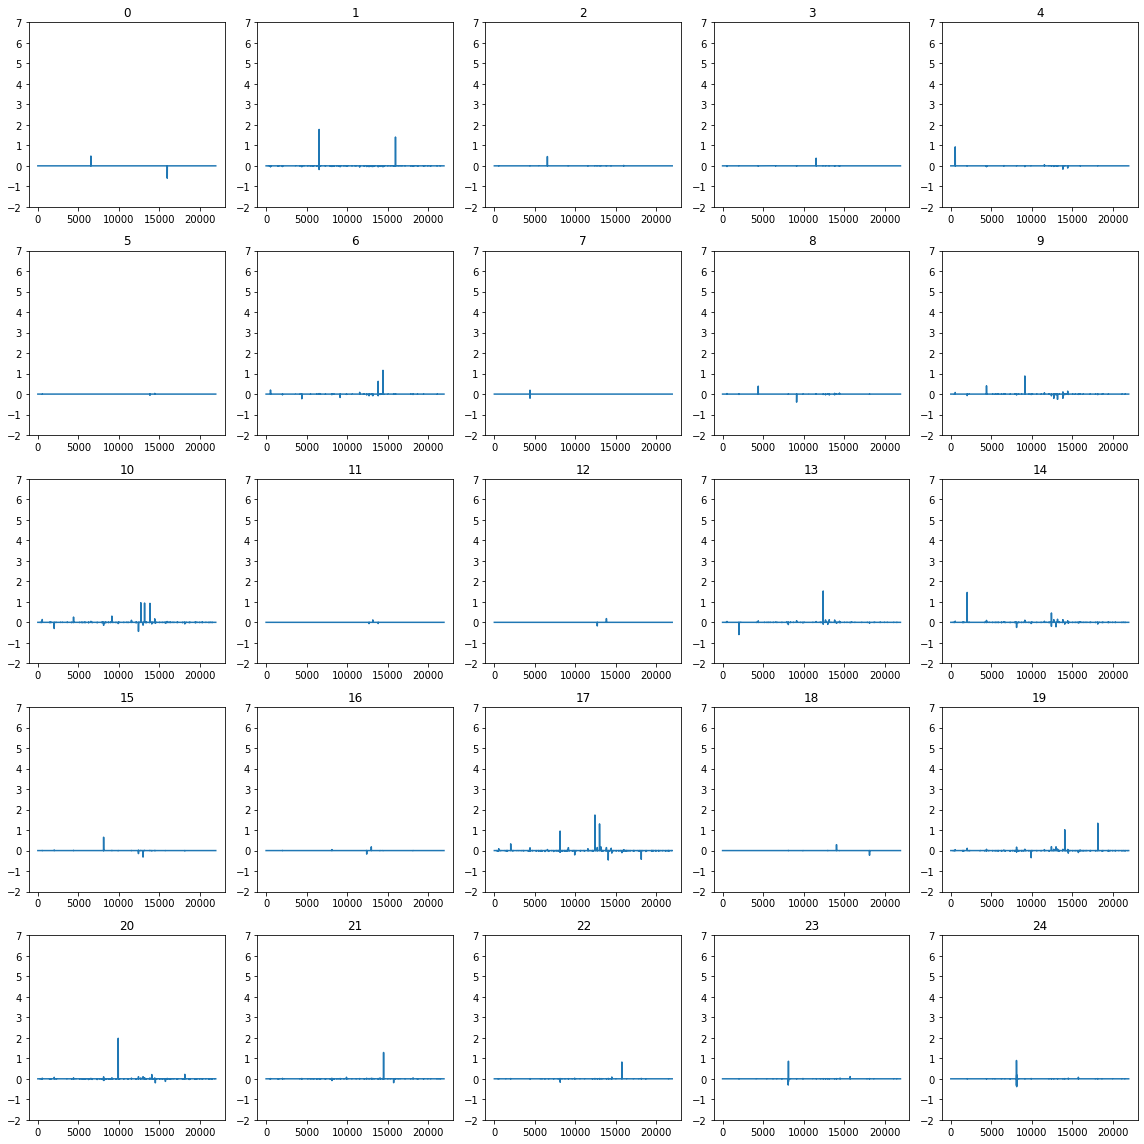

In [452]:
fig,ax =plt.subplots(5,5)
k=0
for i in range(5):
    for j in range(5):
        ax[i][j].plot((f @ np.outer(Ψ[:,k], Ψ[:,k])))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaco

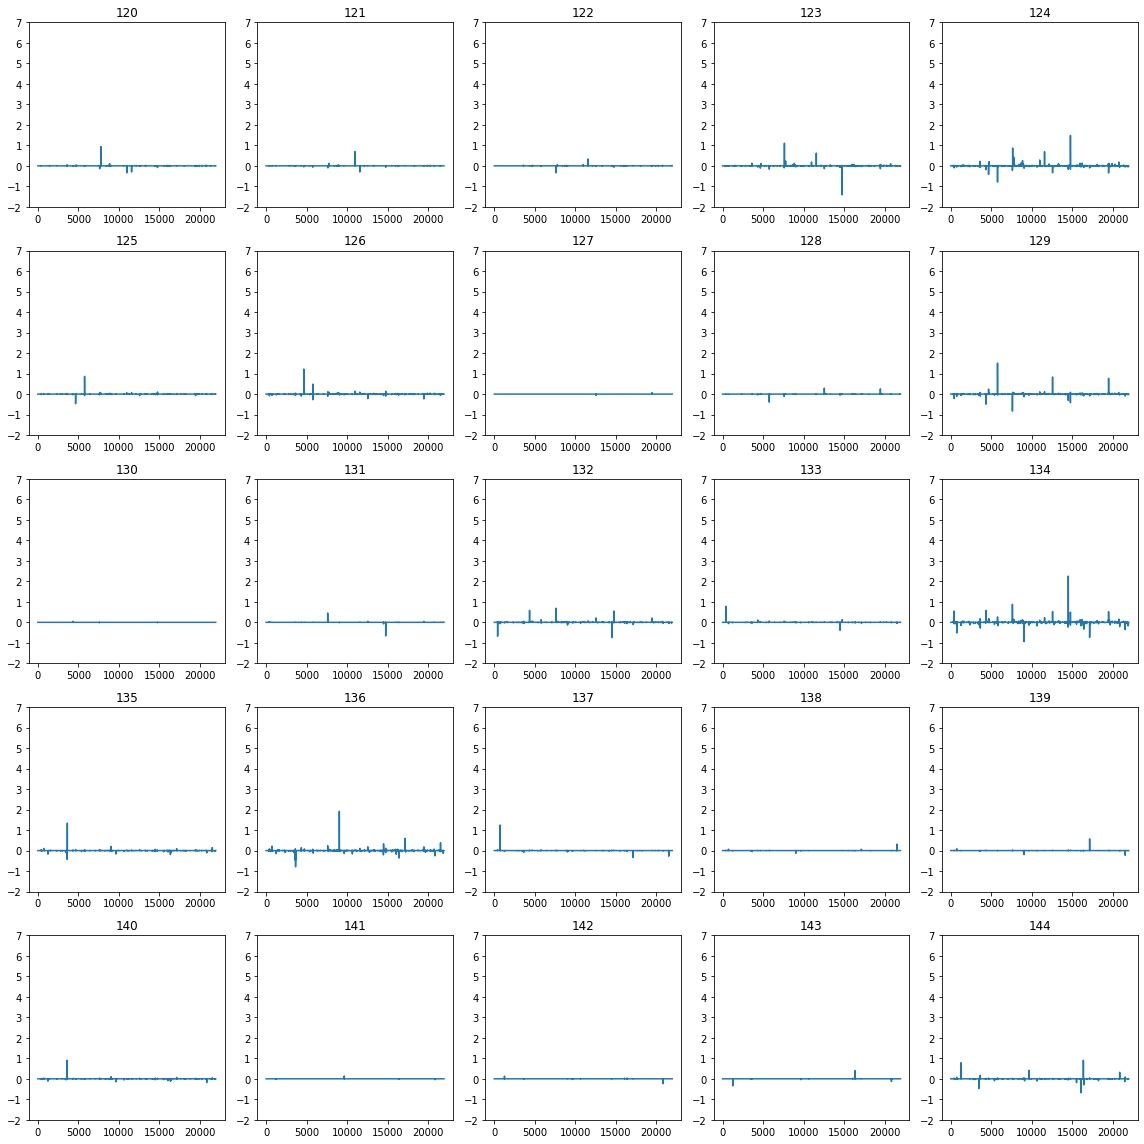

In [453]:
fig,ax =plt.subplots(5,5)
k=120
for i in range(5):
    for j in range(5):
        ax[i][j].plot((f @ np.outer(Ψ[:,k], Ψ[:,k])))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaco

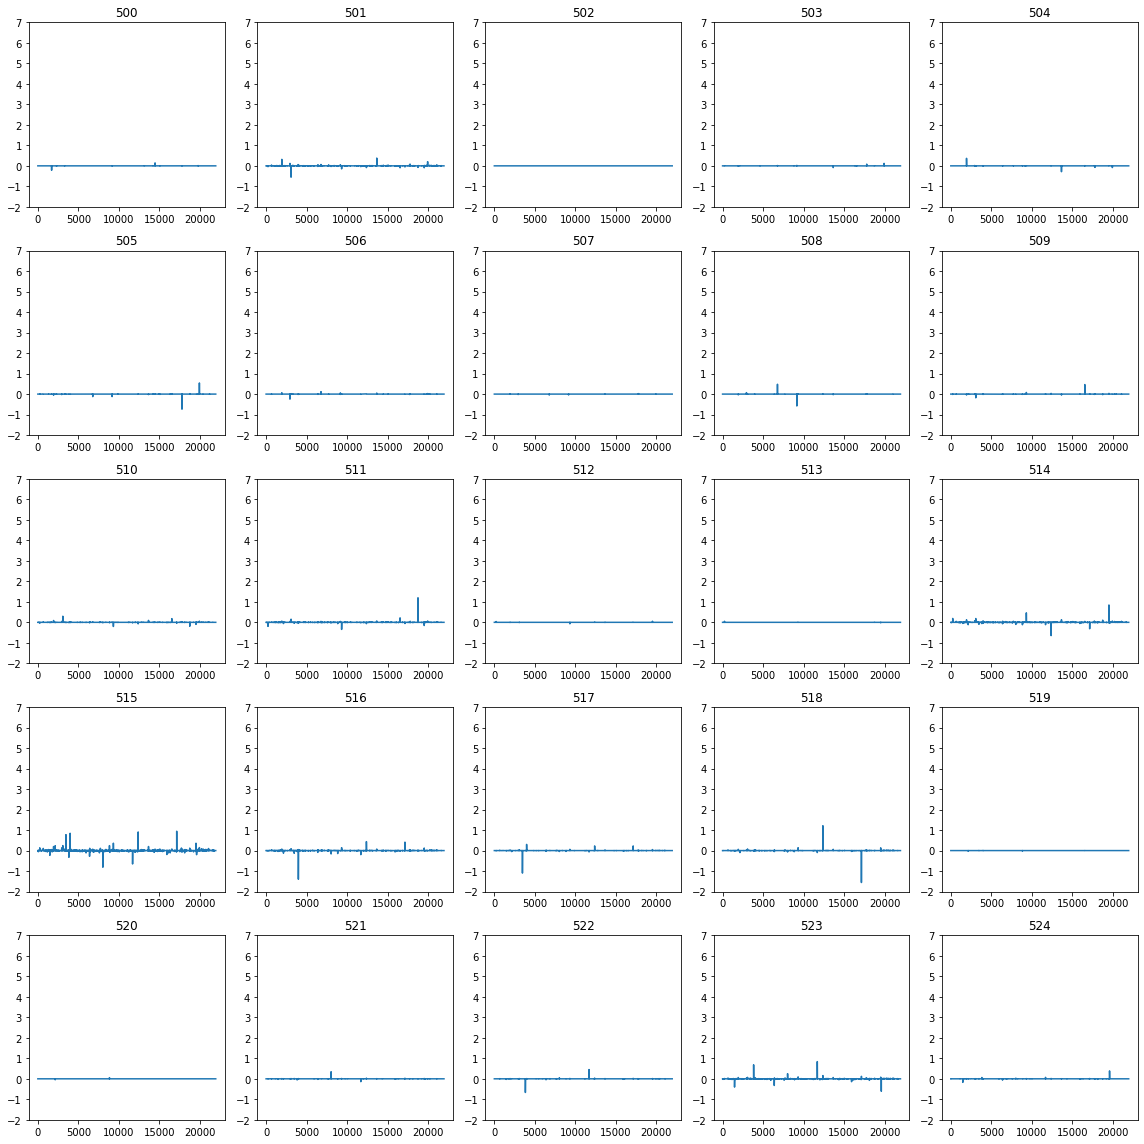

In [454]:
fig,ax =plt.subplots(5,5)
k=500
for i in range(5):
    for j in range(5):
        ax[i][j].plot((f @ np.outer(Ψ[:,k], Ψ[:,k])))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/csy/anaco

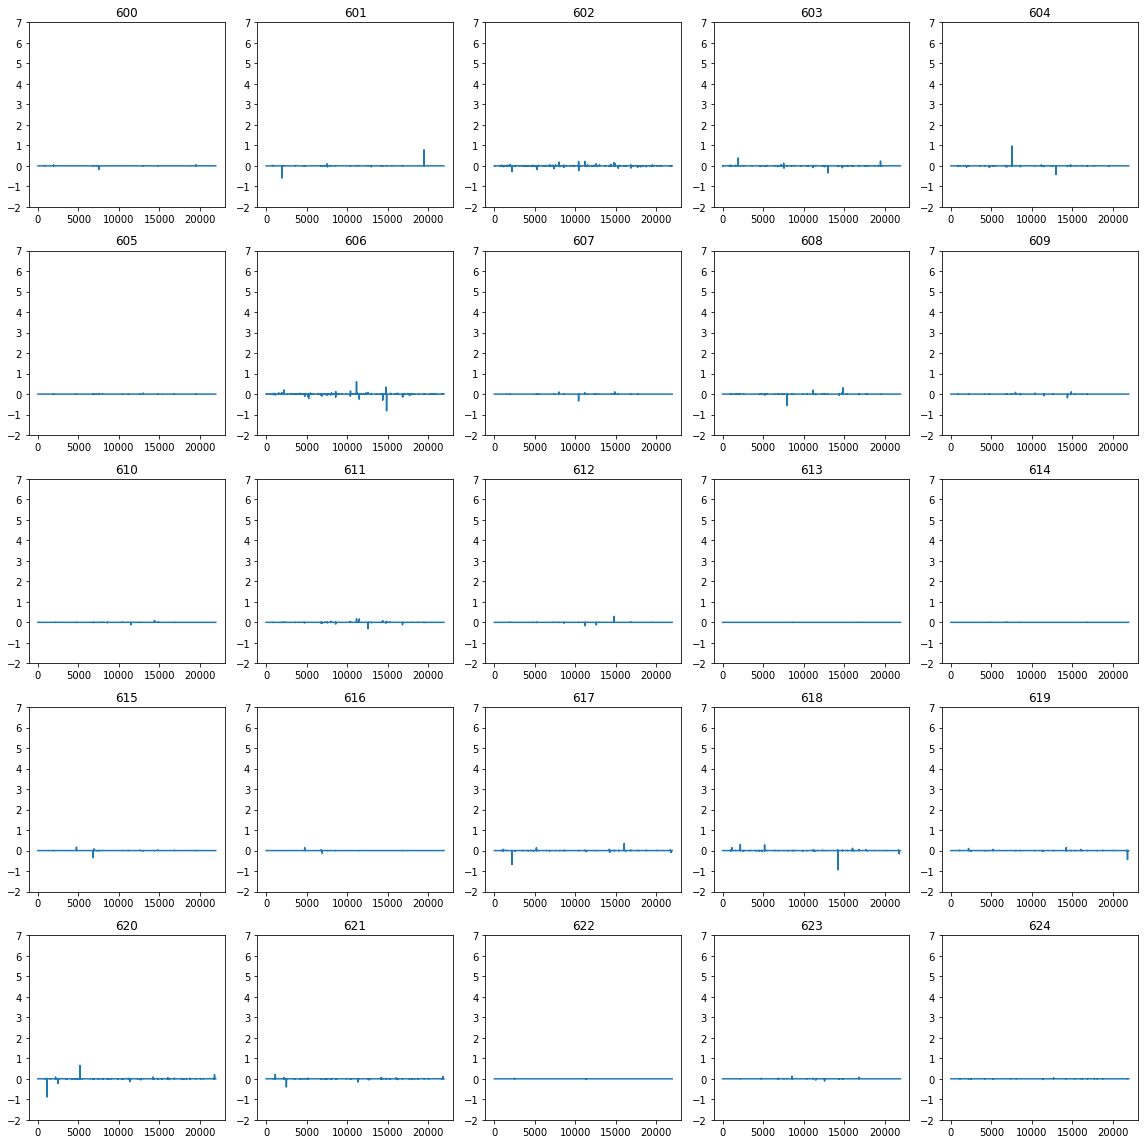

In [455]:
fig,ax =plt.subplots(5,5)
k=600
for i in range(5):
    for j in range(5):
        ax[i][j].plot((f @ np.outer(Ψ[:,k], Ψ[:,k])))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

##### 9. PCA

평균을 나타내는 component

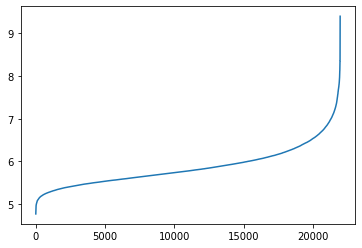

In [456]:
plt.plot(f[np.argsort(f)].reset_index().iloc[:,1])

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


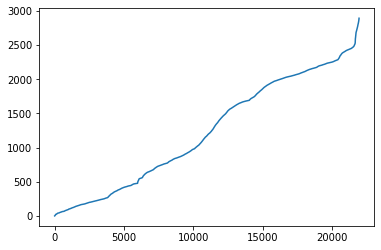

In [457]:
plt.plot(λ[np.argsort(λ)])

component 추정

In [458]:
np.argsort(λ)[0:20]

array([ 347,  494,  586,  587,  901,  588,  590,  589,  904,  905,  585,
        584,  908,  909, 1075,  912,  911, 1076, 1077,  910])

In [459]:
np.argsort(λ)[-10:-1]

array([9, 8, 7, 6, 5, 4, 3, 2, 1])

In [460]:
np.mean(f)

5.872639545178327

In [461]:
np.mean(f @ np.outer(Ψ[:,np.argsort(λ)[0]], Ψ[:,np.argsort(λ)[0]]))

(5.872639545178377+0j)

In [462]:
comphat1=f @ np.outer(Ψ[:,np.argsort(λ)[0]], Ψ[:,np.argsort(λ)[0]])

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


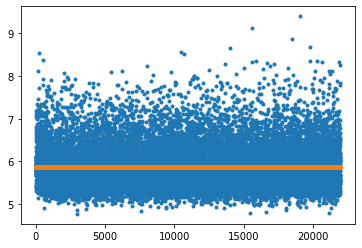

In [463]:
plt.plot(f,'.')
plt.plot(comphat1,'.')

component1 빼고 component2 추정

In [464]:
comphat2 =  f @ np.outer(Ψ[:,np.argsort(λ)[1]], Ψ[:,np.argsort(λ)[1]]) 

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


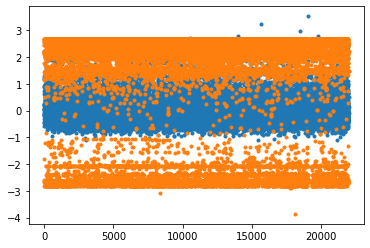

In [465]:
plt.plot(f-comphat1,'.')
plt.plot(comphat2,'.')

In [466]:
comphat3 =  f @ np.outer(Ψ[:,np.argsort(λ)[2]], Ψ[:,np.argsort(λ)[2]]) 

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


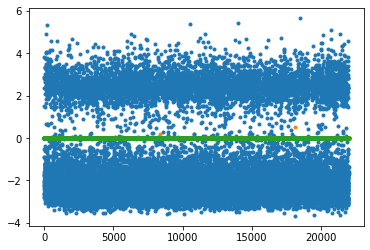

In [467]:
plt.plot(f-comphat1-comphat2,'.')
plt.plot(comphat3,'.')
plt.plot([np.mean(comphat3)]*len(f), '.')

In [468]:
comphat4 =  f @ np.outer(Ψ[:,np.argsort(λ)[3]], Ψ[:,np.argsort(λ)[3]]) 

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


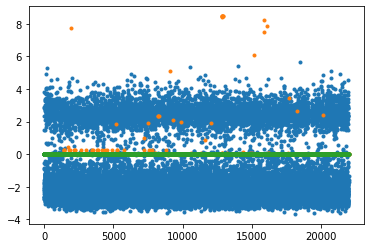

In [469]:
plt.plot(f-comphat1-comphat2-comphat3,'.')
plt.plot(comphat4, '.')
plt.plot([np.mean(comphat4)]*len(f), '.')

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(3.0, 10.0)

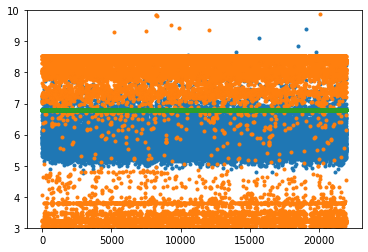

In [470]:
plt.plot(f,'.')
plt.plot(comphat1 + comphat2 + comphat3 + comphat4,'.')
plt.plot([np.mean(comphat1 + comphat2 + comphat3 + comphat4)]*len(f), '.')
plt.ylim(3,10)

In [471]:
f_hat = comphat1 + comphat2 + comphat3 + comphat4

---

ref: https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html

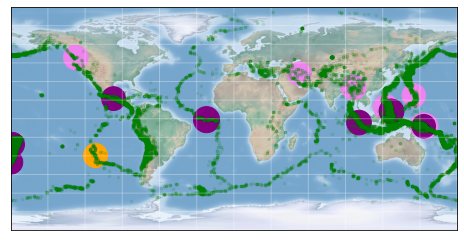

In [472]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 100
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.plot(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], 'r-', markersize=10)
m.scatter(x[np.argsort(λ)[0]], y[np.argsort(λ)[0]], color='orange', s=abs(f[np.argsort(λ)[0]])*scale)
m.scatter(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], color='violet', s=abs(f[np.argsort(λ)[1:10]])*scale)
m.scatter(x[np.argsort(λ)[11:20]], y[np.argsort(λ)[11:20]], color='purple', s=abs(f[np.argsort(λ)[11:20]])*scale)
draw_map(m)

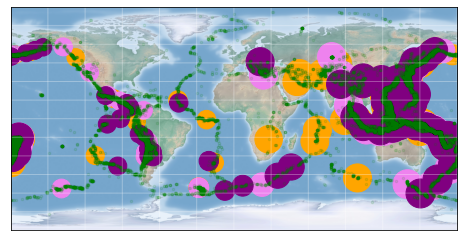

In [476]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 100
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.plot(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], 'r-', markersize=10)
m.scatter(x[np.argsort(λ)[0:100]], y[np.argsort(λ)[0:100]], color='orange', s=abs(f_hat[np.argsort(λ)[0:100]])*scale)
m.scatter(x[np.argsort(λ)[101:200]], y[np.argsort(λ)[101:200]], color='violet', s=abs(f_hat[np.argsort(λ)[101:200]])*scale)
m.scatter(x[np.argsort(λ)[201:300]], y[np.argsort(λ)[201:300]], color='purple', s=abs(f_hat[np.argsort(λ)[201:300]])*scale)
draw_map(m)

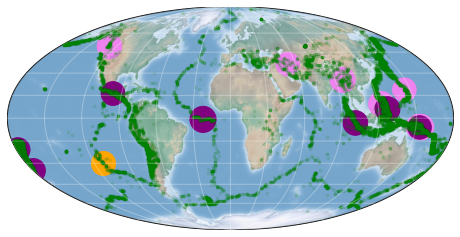

In [474]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='moll', resolution=None,
            lat_0=0, lon_0=0)
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 100
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.plot(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], 'r-', markersize=10)
m.scatter(x[np.argsort(λ)[0]], y[np.argsort(λ)[0]], color='orange', s=abs(f[np.argsort(λ)[0]])*scale)
m.scatter(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], color='violet', s=abs(f[np.argsort(λ)[1:10]])*scale)
m.scatter(x[np.argsort(λ)[11:20]], y[np.argsort(λ)[11:20]], color='purple', s=abs(f[np.argsort(λ)[11:20]])*scale)
draw_map(m)